In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50

# created library
import mydata
from mymodels import TransDataset, ResNet50Model
import training

In [2]:
# to reproduce

seed = 42
random.seed(seed) #　ほかのモジュールで使われているかも
np.random.seed(seed) # ほかのモジュールで使われているかも
torch.manual_seed(seed) # Pytorchの中のシード
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True # GPUの計算過程の変化をさせない

In [3]:
db = "CelebA"
root = f"../../dataset/AAAI 2025/{db}/"
df_train = mydata.load_and_process_csv(f"{root}/dataframe/df_train.csv")
df_valid = mydata.load_and_process_csv(f"{root}/dataframe/df_valid.csv")
df_test = mydata.load_and_process_csv(f"{root}/dataframe/df_test_with_skincolor.csv")

# Data Trainning

In [4]:
ycol="labels"
batch_size = 8
train_loader, valid_loader, test_loader = training.create_dataloaders(df_train, df_valid, df_test, ycol, batch_size)

H*W:  (218, 178)


/home/kuniko/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Accuracy: 0.6621 | Loss: 0.6615 | F1: 0.7012
Validation Accuracy: 0.8157 | Loss: 0.4608 | F1: 0.7992
Validation Accuracy: 0.8519 | Loss: 0.3671 | F1: 0.8621
Validation Accuracy: 0.8770 | Loss: 0.3028 | F1: 0.8716
Validation Accuracy: 0.8579 | Loss: 0.3191 | F1: 0.8404
Validation Accuracy: 0.8895 | Loss: 0.2686 | F1: 0.8868
Validation Accuracy: 0.8868 | Loss: 0.2659 | F1: 0.8783
Validation Accuracy: 0.8898 | Loss: 0.2640 | F1: 0.8819
Validation Accuracy: 0.8822 | Loss: 0.2867 | F1: 0.8725
Validation Accuracy: 0.8786 | Loss: 0.2899 | F1: 0.8660
Validation Accuracy: 0.8871 | Loss: 0.2813 | F1: 0.8763
Validation Accuracy: 0.9013 | Loss: 0.2443 | F1: 0.8971
Validation Accuracy: 0.9035 | Loss: 0.2433 | F1: 0.8999
Validation Accuracy: 0.9047 | Loss: 0.2471 | F1: 0.8999
Validation Accuracy: 0.9092 | Loss: 0.2324 | F1: 0.9073
Validation Accuracy: 0.9086 | Loss: 0.2318 | F1: 0.9057
Validation Accuracy: 0.9120 | Loss: 0.2347 | F1: 0.9115
Validation Accuracy: 0.9144 | Loss: 0.2400 | F1:

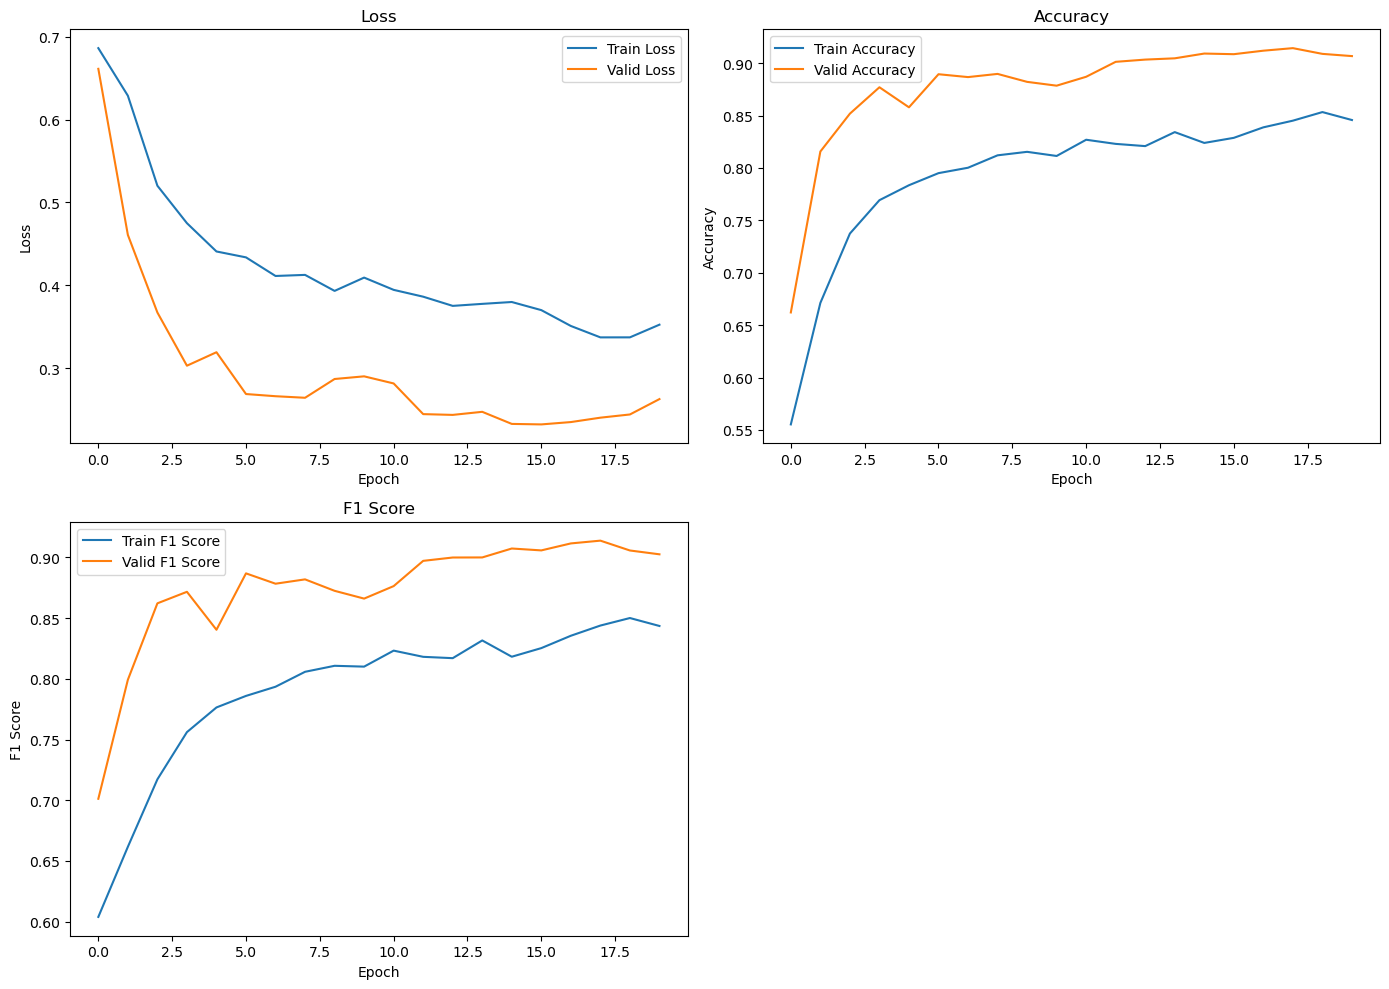

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_save_directory = f"{root}/model/resnet/"
model = ResNet50Model().to(device) # model -> GPU

# Train the model
num_epochs = 20
lr = 0.00001
best_val_file = training.train_model(model, train_loader, valid_loader, model_save_directory, num_epochs=num_epochs, lr=lr)

# Evaluation

In [6]:
model = ResNet50Model().to(device) # model -> GPU
model.load_state_dict(torch.load(best_val_file))

model.eval() # 評価モードに入る。dropoutは学習にしか使わない。dropoutはノイズを入れている。ノイズに耐えられるように。
with torch.no_grad():
    test_predictions = []
    test_outputs = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # data -> GPU
        outputs = model(inputs)
        # _, test_predictions = torch.max(outputs, 1) # outputsの大きい方が選ばれるけど、二値分類なので異なる
        test_outputs.append(outputs)
        test_predictions.extend(1 if x >= 0.5 else 0 for x in outputs) # Appendは１つ、extendは複数

df_test["predictions"] = test_predictions

In [7]:
training.test_classification_report(df_test)
df_test.to_csv(f"../../dataset/AAAI 2025/{db}/evaluation/df_test_resnet.csv", index=False)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2107
           1       0.95      0.85      0.90      2169

    accuracy                           0.90      4276
   macro avg       0.91      0.90      0.90      4276
weighted avg       0.91      0.90      0.90      4276

Skin tone 2: Accuracy 0.8932714617169374
Skin tone 1: Accuracy 0.9085337105139085
